In [ ]:
# importation NLTK->Natural Language Toolkit bib et installation des packeges nécessaires pour le projet
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
!pip install wordcloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# 2ème importation des bibs 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from nltk import word_tokenize
import torch.nn as nn
import pandas as pd
import numpy as np
import pickle
import string 
import torch
import re 
# montage du drive
from google.colab import drive
drive.mount('/content/drive')
# importation de la data
df=pd.read_csv('/content/drive/MyDrive/Data_Projet_IA/Data-FakeRealCOVID.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# création d une copy de la data d'origine
data = df.copy()

In [ ]:
# affichage des infos sur la data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6420 entries, 0 to 6419
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6420 non-null   int64 
 1   tweet   6420 non-null   object
 2   label   6420 non-null   object
dtypes: int64(1), object(2)
memory usage: 150.6+ KB


In [ ]:
# affichage de la data 
data

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real
...,...,...,...
6415,6416,A tiger tested positive for COVID-19 please st...,fake
6416,6417,???Autopsies prove that COVID-19 is??� a blood...,fake
6417,6418,_A post claims a COVID-19 vaccine has already ...,fake
6418,6419,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,fake


In [ ]:
# calcul de nombre des tweets réels et non-réels 
data['label'].value_counts()

real    3360
fake    3060
Name: label, dtype: int64

In [ ]:
# la fonction du cleaning 
def hard_cleaning(text):
  text = text.lower() # conversion de tout l'ensemble en miniscule (normalisation)
  text = re.sub(r'http\S+', '', text) # suppression des liens
  text = re.sub('[^a-zA-Z]+', ' ', text) # laisser juste les alphabets
  return text
# transformer la fonction en une expression lambda
hard_cleaning_LE = lambda x: hard_cleaning(x)

In [ ]:
# appliquer l EL aux données
data.tweet = pd.DataFrame(data.tweet.apply(hard_cleaning_LE))

In [ ]:
# affichage de resultat du cleaning 
data

,id,tweet,label
0,1,the cdc currently reports deaths in general th...,real
1,2,states reported deaths a small rise from last ...,real
2,3,politically correct woman almost uses pandemic...,fake
3,4,indiafightscorona we have covid testing labor...,real
4,5,populous states can generate large case counts...,real
...,...,...,...
6415,6416,a tiger tested positive for covid please stay ...,fake
6416,6417,autopsies prove that covid is a blood clot no...,fake
6417,6418,a post claims a covid vaccine has already bee...,fake
6418,6419,aamir khan donate cr in pm relief cares fund,fake


In [ ]:
# suppression des stopwords 
stop_words = set(stopwords.words('english'))

def remove_en_stop_words(text):
    words = text.split()
    noise_free_words = [word for word in words if word not in stop_words] 
    noise_free_text = " ".join(noise_free_words) 
    return noise_free_text

In [ ]:
# application de la fonction sur la data 
data["tweet"] = data["tweet"].apply(lambda s: remove_en_stop_words(s))

In [ ]:
# affichage de resultat 
data

,id,tweet,label
0,1,cdc currently reports deaths general discrepan...,real
1,2,states reported deaths small rise last tuesday...,real
2,3,politically correct woman almost uses pandemic...,fake
3,4,indiafightscorona covid testing laboratories i...,real
4,5,populous states generate large case counts loo...,real
...,...,...,...
6415,6416,tiger tested positive covid please stay away p...,fake
6416,6417,autopsies prove covid blood clot pneumonia oug...,fake
6417,6418,post claims covid vaccine already developed ca...,fake
6418,6419,aamir khan donate cr pm relief cares fund,fake


In [ ]:
# création d'une instance de limmatizer 
lemmatizer = WordNetLemmatizer()

# fonction d ecriture 
with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
# POS_TAGGER_FUNCTION : TYPE 1
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

In [ ]:
# fonction de limmatization de text 
def text_lemmatizer(text):
  pos_tagged = nltk.pos_tag(nltk.word_tokenize(text)) 
  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
  lemmatized_sentence = []
  for word, tag in wordnet_tagged:
      if tag is None:
          # if there is no available tag, append the token as is
          lemmatized_sentence.append(word)
      else:       
          # else use the tag to lemmatize the token
          lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
  lemmatized_sentence = " ".join(lemmatized_sentence)

  return lemmatized_sentence

In [ ]:
# transformer la fonction en une expression lambda
text_lemmatizer_LE = lambda x: text_lemmatizer(x)

In [ ]:
# application de LE 
data.tweet = pd.DataFrame(data.tweet.apply(text_lemmatizer_LE))

In [ ]:
# donc a ce moment nous avons notre corpus 
corpus = data 
corpus

,id,tweet,label
0,1,cdc currently report death general discrepancy...,real
1,2,state report death small rise last tuesday sou...,real
2,3,politically correct woman almost use pandemic ...,fake
3,4,indiafightscorona covid test laboratory india ...,real
4,5,populous state generate large case count look ...,real
...,...,...,...
6415,6416,tiger test positive covid please stay away pet...,fake
6416,6417,autopsy prove covid blood clot pneumonia ought...,fake
6417,6418,post claim covid vaccine already develop cause...,fake
6418,6419,aamir khan donate cr pm relief care fund,fake


In [ ]:
groups = corpus.groupby(corpus.label)
real_tweets = groups.get_group("real")
fake_tweets =groups.get_group("fake")

In [ ]:
# extration des mots de corpus et calcul de nombre d occ
def bagOfWords(df):
    tokens = []
    bag = {}
    for tweet in df.tweet:
        tokens += word_tokenize(tweet)
    for token in tokens:
        if token not in bag.keys():
            bag[token] = 1
        else:
            bag[token] += 1
    return bag

In [ ]:
real_bow = bagOfWords(real_tweets)
fake_bow = bagOfWords(fake_tweets)

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

%matplotlib inline 

In [ ]:
# Function to convert  
def listToString(s): 
    str1 = " " 
    return (str1.join(s))
    
r = listToString(real_bow.keys())
f = listToString(fake_bow.keys())

In [ ]:
wcr = WordCloud(background_color="white").generate(r)
wcf = WordCloud(background_color="white").generate(f)

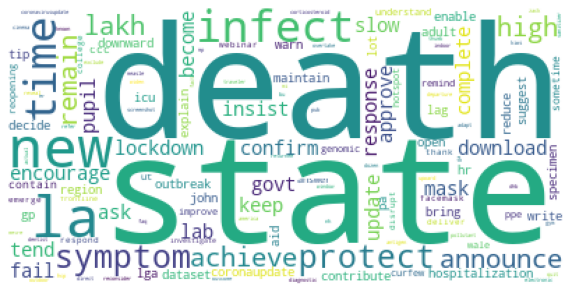

In [ ]:
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(wcr)

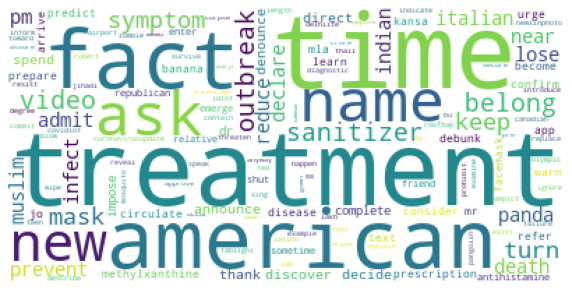

In [ ]:
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(wcf)

In [ ]:
# def du TF-IDF avec le seuil d'acceptation entre min 1% et max 90%
tfidf = TfidfVectorizer(min_df=.001, max_df=.9).fit(data.tweet)
# resultat final (document term matrix)
dtm = pd.DataFrame(tfidf.transform(data.tweet).toarray(), columns=tfidf.get_feature_names_out())

In [ ]:
dtm

,abia,ability,able,acc,accelerate,accelerator,accept,access,accord,account,accurate,achieve,acquire,across,act,action,active,activity,actor,actually,acute,adamawa,add,addition,additional,address,adjust,administration,administrator,admission,admit,adult,advice,advise,advisory,affair,affect,affected,africa,african,...,white,whole,whose,wide,widely,widespread,wife,wildfire,win,window,winter,wise,within,without,woman,wonder,word,work,worker,workplace,world,worldwide,worth,would,write,wrong,wuhan,year,yes,yesterday,yet,yobe,york,young,youtube,zamfara,zealand,zero,zinc,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300584,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
6416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.320977,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.219544,0.0,0.0,0.0,0.0,0.334429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
6417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.474801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
6418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
# pickling object on file

# fonction d ecriture 
with open('dtm.pkl', 'wb') as f:
    pickle.dump(dtm, f)
    
# fonction de la lecture 
# with open('dtm.pkl', 'rb') as f:
#     dtm = pickle.load(f)

In [ ]:
# extraction des labels de la data
labels = data.label
# transformation vers numpy obj
labels = np.array(labels)
# transformer real en  1 et fake en 0 
labels = np.where(labels == 'real', 1, 0)

# fonction d ecriture 
with open('labels.pkl', 'wb') as f:
    pickle.dump(labels, f)
# transformation en obj tensor (preparation pour la phase d'apprentissage)
targets = torch.tensor(labels)
targets

tensor([1, 1, 0,  ..., 0, 0, 1])

In [ ]:
# transformation du DTM en obj tensor
data = torch.tensor(dtm.to_numpy())

In [ ]:
data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

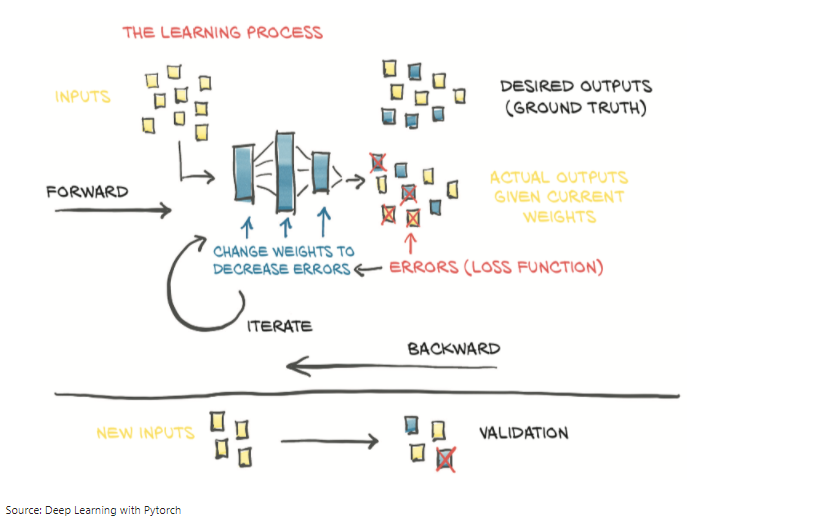

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/Colab Notebooks/Capture d’écran 2022-02-28 011901.png')

In [ ]:
# division de la data sur deux ( data d' apprentissage et data de test )
x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, shuffle=True)

In [ ]:
# visualisation de la forme du data
x_train.shape

torch.Size([5136, 1888])

In [ ]:
# divistion de la data d' apprentissage en data d'apprentissage et de validation 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [ ]:
# création d une classe qui va nous permettre d avoir la partie de la data avec labels qui convient 
# forme du dataset est dataset(data, targets)
class MonDataset ( Dataset ):
    def __init__(self, data, targets):
        super(MonDataset).__init__()
        self.data = data
        self.targets = targets
  
    def __getitem__(self, idx):
        return self.data[idx],self.targets[idx]
  
    def __len__(self):
        return len(self.targets)

In [ ]:
# création des datasets 
Dataset_train = MonDataset(x_train,y_train)
Dataset_val = MonDataset(x_val,y_val)
Dataset_test = MonDataset(x_test,y_test)

In [ ]:
# batch_size est un hyperparamètre qui définit le nombre d'échantillons à traiter avant de mettre à jour les paramètres du modèle interne.
batch_size = 128
# création du dataloader ( dataset + les batchs_size)
Dataloader_train = DataLoader(Dataset_train , batch_size)
Dataloader_val = DataLoader(Dataset_val , batch_size)
Dataloader_test = DataLoader(Dataset_test , batch_size)

In [ ]:
print(len(Dataset_train))
print(len(Dataloader_train))

4108
33


In [ ]:
# architecture du 1er modèle
class NN1(nn.Module):

    def __init__(self):
        super(NN1, self).__init__()
        self.fc1 = nn.Linear(1888, 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [ ]:
# architecture du 2ème modèle
class NN2(nn.Module):

    def __init__(self):
        super(NN2, self).__init__()
        self.fc1 = nn.Linear(1888, 256) 
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2)


    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [ ]:
# architecture du 3ème modèle
class NN3(nn.Module):

    def __init__(self):
        super(NN3, self).__init__()
        self.fc1 = nn.Linear(1888, 512) 
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [ ]:
# architecture du 4ème modèle
class NN4(nn.Module):

    def __init__(self):
        super(NN4, self).__init__()
        self.fc1 = nn.Linear(1888, 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

The Cross-Entropy function has a wide range of variants, of which the most common type is the Binary Cross-Entropy (BCE). The BCE Loss is mainly used for binary classification models; that is, models having only 2 classes

In [ ]:
# definition de la fonction de loss 
loss_function = nn.CrossEntropyLoss()

In [ ]:
# création des modèles selon les architectures précédemments definies
model11 = NN1()
model12 = NN1()
model13 = NN1()

model21 = NN2()
model22 = NN2()
model23 = NN2()

model31 = NN3()
model32 = NN3()
model33 = NN3()

model41 = NN4()
model42 = NN4()
model43 = NN4()


In [ ]:
# définition des optimiseurs et de hyperparamétre Learning rate 

optimizer11 = torch.optim.SGD(model11.parameters() , lr = 0.001)
optimizer12 = torch.optim.Adam(model12.parameters() ,lr = 0.001)
optimizer13 = torch.optim.Adam(model13.parameters() ,lr = 0.0001)

optimizer21 = torch.optim.SGD(model21.parameters() , lr = 0.001)
optimizer22 = torch.optim.Adam(model22.parameters() ,lr = 0.001)
optimizer23 = torch.optim.Adam(model23.parameters() ,lr = 0.0001)

optimizer31 = torch.optim.SGD(model31.parameters() , lr = 0.001)
optimizer32 = torch.optim.Adam(model32.parameters() ,lr = 0.001)
optimizer33 = torch.optim.Adam(model33.parameters() ,lr = 0.0001)

optimizer41 = torch.optim.SGD(model41.parameters() , lr = 0.001)
optimizer42 = torch.optim.Adam(model42.parameters() ,lr = 0.001)
optimizer43 = torch.optim.Adam(model43.parameters() ,lr = 0.0001)

In [ ]:
#source : pytorch docs 

# boucle d'apprentissage:
def train_model_func(epoch, net, optimizer):
      losses_train = []
      losses_val = []
      # The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.
      for ep in range(epoch):
          # initialisation de la valeur d err à 0
          train_loss = 0
          # boucle sur les mini-batchs de notre dataset d apprentissage
          for data,targets in Dataloader_train:
              # resultat de la prédiction sur l'i eme mini-batch ( apprentissage )
              output = net(data.float())
              # calcul de l err 
              loss = loss_function(output, targets)
              # Backpropagation: 
              # réinitialiser l'optimiseur
              optimizer.zero_grad()
              loss.backward()
              # effectuer un pas d optimisation
              optimizer.step()
              # mettre à jour votre coût (err) d'apprentissage en lui ajoutant le err du batch
              train_loss +=  loss.item() 
          losses_train.append(train_loss/len(Dataset_train))
          # calcul de l err moyenne pour l ensemble des données d apprentissage 
          train_loss /= len(Dataset_train)
          

          # boucle de validation:
          # valeur d err dans la phase de validation 
          valid_loss = 0
          # la valeur des prédictions correctes 
          valid_acc = 0
          # Indiquer à Pytorch qu'on ne va pas calculer le Gradient ( spécifier le mode de validation )
          with torch.no_grad():
              # boucle sur les mini-batchs de notre dataset de validation
              for data,targets in Dataloader_val:
                  # resultat de la prédiction sur l'i eme mini-batch
                  output = net(data.float())
                  # resultat de la prédiction sur l'i eme mini-batch ( validation )
                  loss = loss_function(output, targets)
                  # mettre à jour votre coût (err) d'apprentissage en lui ajoutant le err du batch
                  valid_loss +=  loss.item()
                  # calcul de la somme des prédictions correctes 
                  valid_acc += torch.sum(torch.argmax(output, dim=1) == targets).item()
              losses_val.append(valid_loss/len(Dataset_val))
              # err moyenne dans la dataset de validation   
              valid_loss /= len(Dataset_val)
              # le nombre de prédiction moyenne de la dataset de validation 
              valid_acc /= len(Dataset_val)
              
          
          print(f"epoch: {ep}, train loss: {train_loss:.4f}, validation loss: {valid_loss:.4f}, correct predictions: {valid_acc*100:.2f}%")

      plt.plot(losses_train , color="red")
      plt.plot(losses_val  , color="green")

In [ ]:
#  rénitialisation des paramétres de modèle 
def weight_reset(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()

ne = 20 

epoch: 0, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 1, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 2, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 3, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 4, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 5, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 6, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 7, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 8, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 9, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 10, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 11, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
ep

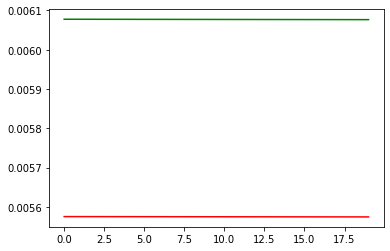

In [ ]:
weight_reset(model11)
# appel à la fonction d'apprentissage avec les trois params ( nb epochs - modèle - optimiseur)
train_model_func(ne, model11, optimizer11)

epoch: 0, train loss: 0.0055, validation loss: 0.0057, correct predictions: 89.11%
epoch: 1, train loss: 0.0045, validation loss: 0.0042, correct predictions: 91.63%
epoch: 2, train loss: 0.0033, validation loss: 0.0037, correct predictions: 92.61%
epoch: 3, train loss: 0.0030, validation loss: 0.0036, correct predictions: 92.41%
epoch: 4, train loss: 0.0028, validation loss: 0.0036, correct predictions: 92.12%
epoch: 5, train loss: 0.0027, validation loss: 0.0036, correct predictions: 91.54%
epoch: 6, train loss: 0.0027, validation loss: 0.0036, correct predictions: 91.54%
epoch: 7, train loss: 0.0027, validation loss: 0.0036, correct predictions: 91.34%
epoch: 8, train loss: 0.0026, validation loss: 0.0036, correct predictions: 91.25%
epoch: 9, train loss: 0.0026, validation loss: 0.0036, correct predictions: 91.34%
epoch: 10, train loss: 0.0026, validation loss: 0.0036, correct predictions: 91.05%
epoch: 11, train loss: 0.0026, validation loss: 0.0037, correct predictions: 90.95%
ep

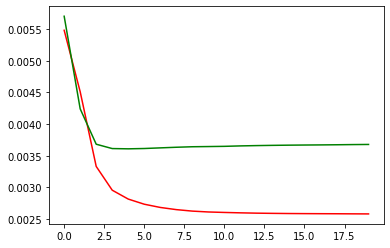

In [ ]:
weight_reset(model12)
train_model_func(ne, model12, optimizer12)

epoch: 0, train loss: 0.0056, validation loss: 0.0061, correct predictions: 48.25%
epoch: 1, train loss: 0.0056, validation loss: 0.0061, correct predictions: 88.13%
epoch: 2, train loss: 0.0055, validation loss: 0.0060, correct predictions: 85.31%
epoch: 3, train loss: 0.0055, validation loss: 0.0060, correct predictions: 88.04%
epoch: 4, train loss: 0.0054, validation loss: 0.0059, correct predictions: 89.79%
epoch: 5, train loss: 0.0053, validation loss: 0.0057, correct predictions: 90.37%
epoch: 6, train loss: 0.0052, validation loss: 0.0056, correct predictions: 90.47%
epoch: 7, train loss: 0.0050, validation loss: 0.0054, correct predictions: 90.76%
epoch: 8, train loss: 0.0048, validation loss: 0.0051, correct predictions: 91.05%
epoch: 9, train loss: 0.0045, validation loss: 0.0049, correct predictions: 91.25%
epoch: 10, train loss: 0.0043, validation loss: 0.0047, correct predictions: 91.83%
epoch: 11, train loss: 0.0041, validation loss: 0.0045, correct predictions: 92.02%
ep

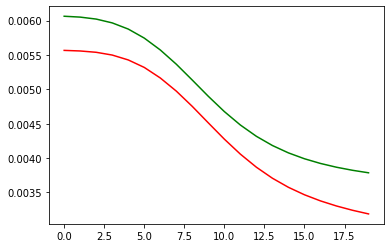

In [ ]:
weight_reset(model13)
train_model_func(ne, model13, optimizer13)

epoch: 0, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 1, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 2, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 3, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 4, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 5, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 6, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 7, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 8, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 9, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 10, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 11, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
ep

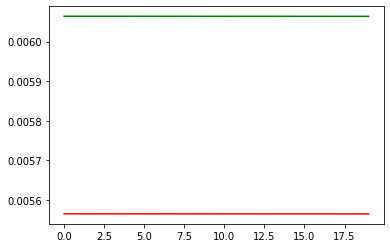

In [ ]:
weight_reset(model21)
train_model_func(ne, model21, optimizer21)

epoch: 0, train loss: 0.0053, validation loss: 0.0049, correct predictions: 88.33%
epoch: 1, train loss: 0.0035, validation loss: 0.0036, correct predictions: 91.93%
epoch: 2, train loss: 0.0028, validation loss: 0.0036, correct predictions: 91.44%
epoch: 3, train loss: 0.0027, validation loss: 0.0036, correct predictions: 91.15%
epoch: 4, train loss: 0.0027, validation loss: 0.0036, correct predictions: 91.34%
epoch: 5, train loss: 0.0026, validation loss: 0.0037, correct predictions: 91.05%
epoch: 6, train loss: 0.0026, validation loss: 0.0036, correct predictions: 91.25%
epoch: 7, train loss: 0.0026, validation loss: 0.0037, correct predictions: 90.95%
epoch: 8, train loss: 0.0026, validation loss: 0.0037, correct predictions: 91.25%
epoch: 9, train loss: 0.0026, validation loss: 0.0037, correct predictions: 90.95%
epoch: 10, train loss: 0.0026, validation loss: 0.0037, correct predictions: 91.15%
epoch: 11, train loss: 0.0026, validation loss: 0.0037, correct predictions: 91.05%
ep

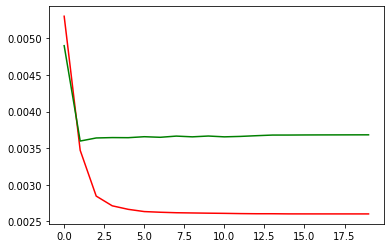

In [ ]:
weight_reset(model22)
train_model_func(ne, model22, optimizer22)

epoch: 0, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 1, train loss: 0.0056, validation loss: 0.0060, correct predictions: 53.11%
epoch: 2, train loss: 0.0055, validation loss: 0.0060, correct predictions: 79.18%
epoch: 3, train loss: 0.0054, validation loss: 0.0058, correct predictions: 88.52%
epoch: 4, train loss: 0.0052, validation loss: 0.0055, correct predictions: 90.27%
epoch: 5, train loss: 0.0048, validation loss: 0.0051, correct predictions: 90.66%
epoch: 6, train loss: 0.0043, validation loss: 0.0045, correct predictions: 91.73%
epoch: 7, train loss: 0.0038, validation loss: 0.0041, correct predictions: 92.51%
epoch: 8, train loss: 0.0034, validation loss: 0.0039, correct predictions: 92.70%
epoch: 9, train loss: 0.0032, validation loss: 0.0038, correct predictions: 93.09%
epoch: 10, train loss: 0.0031, validation loss: 0.0037, correct predictions: 92.80%
epoch: 11, train loss: 0.0030, validation loss: 0.0037, correct predictions: 92.51%
ep

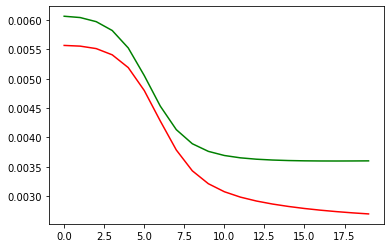

In [ ]:
weight_reset(model23)
train_model_func(ne, model23, optimizer23)

epoch: 0, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 1, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 2, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 3, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 4, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 5, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 6, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 7, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 8, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 9, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 10, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 11, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
ep

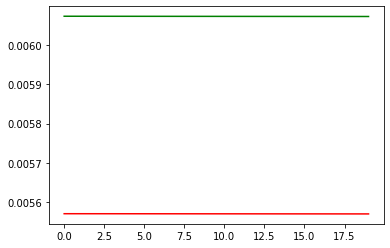

In [ ]:
weight_reset(model31)
train_model_func(ne, model31, optimizer31)

epoch: 0, train loss: 0.0050, validation loss: 0.0041, correct predictions: 91.05%
epoch: 1, train loss: 0.0032, validation loss: 0.0036, correct predictions: 92.80%
epoch: 2, train loss: 0.0028, validation loss: 0.0036, correct predictions: 91.15%
epoch: 3, train loss: 0.0027, validation loss: 0.0036, correct predictions: 91.15%
epoch: 4, train loss: 0.0026, validation loss: 0.0037, correct predictions: 91.05%
epoch: 5, train loss: 0.0026, validation loss: 0.0037, correct predictions: 90.47%
epoch: 6, train loss: 0.0026, validation loss: 0.0037, correct predictions: 90.47%
epoch: 7, train loss: 0.0026, validation loss: 0.0037, correct predictions: 90.37%
epoch: 8, train loss: 0.0026, validation loss: 0.0037, correct predictions: 90.37%
epoch: 9, train loss: 0.0026, validation loss: 0.0037, correct predictions: 90.66%
epoch: 10, train loss: 0.0026, validation loss: 0.0037, correct predictions: 90.76%
epoch: 11, train loss: 0.0026, validation loss: 0.0037, correct predictions: 90.76%
ep

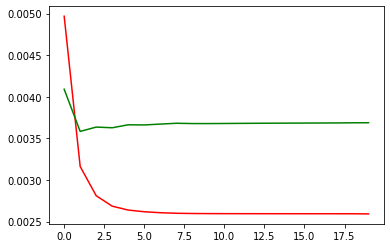

In [ ]:
weight_reset(model32)
train_model_func(ne, model32, optimizer32)

epoch: 0, train loss: 0.0056, validation loss: 0.0061, correct predictions: 83.46%
epoch: 1, train loss: 0.0055, validation loss: 0.0060, correct predictions: 82.88%
epoch: 2, train loss: 0.0054, validation loss: 0.0057, correct predictions: 88.13%
epoch: 3, train loss: 0.0050, validation loss: 0.0053, correct predictions: 89.20%
epoch: 4, train loss: 0.0045, validation loss: 0.0047, correct predictions: 90.56%
epoch: 5, train loss: 0.0039, validation loss: 0.0042, correct predictions: 91.83%
epoch: 6, train loss: 0.0036, validation loss: 0.0040, correct predictions: 92.12%
epoch: 7, train loss: 0.0033, validation loss: 0.0038, correct predictions: 92.32%
epoch: 8, train loss: 0.0032, validation loss: 0.0037, correct predictions: 92.51%
epoch: 9, train loss: 0.0031, validation loss: 0.0037, correct predictions: 93.00%
epoch: 10, train loss: 0.0030, validation loss: 0.0037, correct predictions: 92.70%
epoch: 11, train loss: 0.0029, validation loss: 0.0036, correct predictions: 92.51%
ep

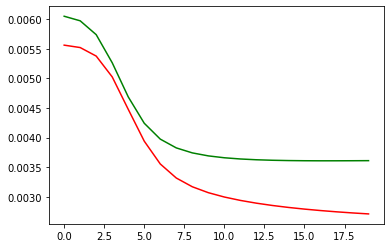

In [ ]:
weight_reset(model33)
train_model_func(ne, model33, optimizer33)

epoch: 0, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 1, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 2, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 3, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 4, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 5, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 6, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 7, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 8, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 9, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 10, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 11, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
ep

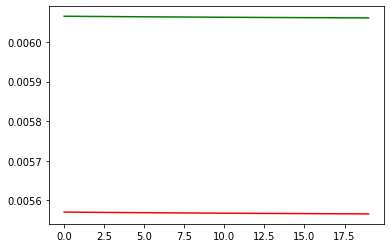

In [ ]:
weight_reset(model41)
train_model_func(ne, model41, optimizer41)

epoch: 0, train loss: 0.0056, validation loss: 0.0060, correct predictions: 52.82%
epoch: 1, train loss: 0.0055, validation loss: 0.0060, correct predictions: 52.82%
epoch: 2, train loss: 0.0055, validation loss: 0.0059, correct predictions: 54.47%
epoch: 3, train loss: 0.0052, validation loss: 0.0054, correct predictions: 90.27%
epoch: 4, train loss: 0.0045, validation loss: 0.0046, correct predictions: 89.20%
epoch: 5, train loss: 0.0038, validation loss: 0.0041, correct predictions: 90.08%
epoch: 6, train loss: 0.0035, validation loss: 0.0039, correct predictions: 90.66%
epoch: 7, train loss: 0.0033, validation loss: 0.0038, correct predictions: 91.25%
epoch: 8, train loss: 0.0032, validation loss: 0.0037, correct predictions: 91.54%
epoch: 9, train loss: 0.0031, validation loss: 0.0037, correct predictions: 91.73%
epoch: 10, train loss: 0.0030, validation loss: 0.0037, correct predictions: 92.12%
epoch: 11, train loss: 0.0030, validation loss: 0.0036, correct predictions: 92.32%
ep

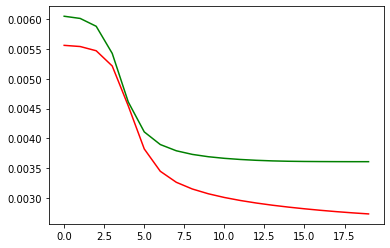

In [ ]:
weight_reset(model42)
train_model_func(ne, model42, optimizer42)

epoch: 0, train loss: 0.0056, validation loss: 0.0061, correct predictions: 47.18%
epoch: 1, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 2, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 3, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 4, train loss: 0.0056, validation loss: 0.0061, correct predictions: 52.82%
epoch: 5, train loss: 0.0056, validation loss: 0.0060, correct predictions: 52.82%
epoch: 6, train loss: 0.0056, validation loss: 0.0060, correct predictions: 52.82%
epoch: 7, train loss: 0.0056, validation loss: 0.0060, correct predictions: 52.82%
epoch: 8, train loss: 0.0055, validation loss: 0.0060, correct predictions: 52.82%
epoch: 9, train loss: 0.0055, validation loss: 0.0060, correct predictions: 52.82%
epoch: 10, train loss: 0.0055, validation loss: 0.0060, correct predictions: 52.82%
epoch: 11, train loss: 0.0055, validation loss: 0.0060, correct predictions: 52.82%
ep

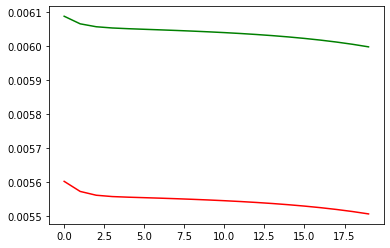

In [ ]:
weight_reset(model43)
train_model_func(ne, model43, optimizer43)

In [ ]:
# boucle de test:
def test_model(net):
    # variable de cout ( err ) dans la phase de test 
    test_loss = 0
    # variable de nombre des prévisions correctes 
    correct = 0
    # no_grad signifie pas de calcul de gradient
    with torch.no_grad():
        # boucle sur les mini-batchs de notre dataset de test
        for data,targets in Dataloader_test:
            # resultat de la prédiction sur l'i eme mini-batch
            output = net(data.float())
            # calcul de l'erreur entre les targets et les prédictions
            loss = loss_function (output, targets)
            # sommation des erreurs 
            test_loss += loss.item()
            # sommation des prédictions correctes 
            correct += torch.sum(torch.argmax(output, dim=1) == targets).item()
            
        # l err moyenne 
        test_loss /= len(Dataloader_test)
        # nombre moyenne des prédictions correctes 
        correct /= len(Dataset_test) 
    
    print(f"Accuracy {correct*100:.2f}%")

In [ ]:
test_model(model11)
test_model(model12)
test_model(model13)
print("*-------------------------------*")
test_model(model21)
test_model(model22)
test_model(model23)
print("*-------------------------------*")
test_model(model31)
test_model(model32)
test_model(model33)
print("*-------------------------------*")
test_model(model41)
test_model(model42)
test_model(model43)

Accuracy 47.04%
Accuracy 91.82%
Accuracy 92.60%
*-------------------------------*
Accuracy 52.96%
Accuracy 91.12%
Accuracy 92.68%
*-------------------------------*
Accuracy 47.04%
Accuracy 91.74%
Accuracy 92.76%
*-------------------------------*
Accuracy 52.96%
Accuracy 92.68%
Accuracy 52.96%


In [ ]:
print("more infos about our model : ")
print("Our mode l: \n\n", model22, '\n')
print("The state dict keys: \n\n", model22.state_dict().keys())

more infos about our model : 
Our mode l: 

 NN2(
  (fc1): Linear(in_features=1888, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [ ]:
torch.save(model23.state_dict(), 'model_weights.pth')

In [ ]:
# fonction qui fait le nettoyage, suppression des SW ,et lemmatisation pour un texte donné en paramétre 
def text_to_corpus(text):
  text = hard_cleaning(text)
  text = remove_en_stop_words(text)
  text = text_lemmatizer(text)
  return text 

In [ ]:
# test sur un tweet réel  
text = " Deeply saddened & heartbroken by the passing of my dear friend & outstanding global health champion, Dr Paul Farmer. He led so many efforts for #healthequity & against root causes of injustices. We must never stop continuing his legacy. You will be so greatly missed my friend. "
newtext = text_to_corpus(text)

In [ ]:
newtext

'deeply sadden heartbroken pass dear friend outstanding global health champion dr paul farmer lead many effort healthequity root cause injustice must never stop continue legacy greatly miss friend'

In [ ]:
# transformer le texte vers la forme de notre DTM (calcul de tf-idf pour le texte donné selon matrice de tf-idf de base )
data_to_pred = torch.tensor(tfidf.transform([newtext]).toarray())

In [ ]:
# tf-idf pour le tweet qu on va faire le test sur 
data_to_pred

tensor([[0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [ ]:
# la prédiction 
prediction = model22(data_to_pred.float())

In [ ]:
# résultat de la prédiction 
torch.argmax(prediction)

tensor(1)